In [45]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials
import seaborn as sns
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score

In [28]:
id_to_label = {
    0: "Normal",
    1: "Supraventricular Ectopic Beats",
    2: "Ventricular Ectopic Beats",
    3: "Fusion Beats",
    4: "Unclassifiable Beats"
}

In [29]:
df_train = pd.read_csv("mitbih_train.csv", header = None)
df_test = pd.read_csv("mitbih_test.csv", header = None)

y_train = df_train.iloc[:, -1]
X_train = df_train.iloc[:, :-1]

y_test = df_test.iloc[:, -1]
X_test = df_test.iloc[:, :-1]

In [30]:
X = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)

y = pd.concat([y_train, y_test], axis=0).reset_index(drop=True).astype(int)

X.shape, y.shape

((109446, 187), (109446,))

## EDA

In [31]:
fig_train = px.histogram(y_train, x=187, title="Label Distribution in y_train", 
                         text_auto=True, labels={"Label": "Class Labels"},
                         color= 187)  
fig_train.update_layout(
    xaxis_title="Class",
    yaxis_title="Num Samples",
    legend_title="Class",
    template="plotly_white",
    height = 600
)

fig_train.show()

In [32]:
fig_pie = px.pie(y_train, names = 187, title="Percentage Label Distribution in y_train", hole=0.3)
fig_pie.update_layout(
    xaxis_title="Class",
    yaxis_title="Num Samples",
    legend_title="Class",
    template="plotly_white",
    height = 1000
)
fig_pie.show()

In [33]:
fig_test = px.histogram(y_test, x=187, title="Label Distribution in y_test", 
                         text_auto=True, labels={"Label": "Class Labels"},
                         color= 187)  
fig_test.update_layout(
    xaxis_title="Class",
    yaxis_title="Num Samples",
    legend_title="Class",
    template="plotly_white",
    height = 600
)
fig_test.show()

In [34]:
fig_pie = px.pie(y_test, names = 187, title="Percentage Label Distribution in y_test", hole=0.3)
fig_pie.update_layout(
    xaxis_title="Class",
    yaxis_title="Num Samples",
    legend_title="Class",
    template="plotly_white",
    height = 1000
)
fig_pie.show()

In [35]:
num_samples = 5  
unique_classes = y.unique()  
selected_indices = []

for cls in unique_classes:
    class_indices = y[y == cls].index 
    num_to_sample = min(1, len(class_indices)) 
    selected_indices.extend(np.random.choice(class_indices, num_to_sample, replace=False))

remaining_samples = num_samples - len(selected_indices)
if remaining_samples > 0:
    additional_indices = y.drop(selected_indices).sample(remaining_samples, random_state=42).index
    selected_indices.extend(additional_indices)

fig = go.Figure()

for i, idx in enumerate(selected_indices):
    label_id = y.loc[idx] 
    label_name = id_to_label[int(label_id)] 

    fig.add_trace(go.Scatter(
        y=X.loc[idx].values,
        mode='lines',
        name=f"ECG {i+1} - {label_name}"
    ))

fig.update_layout(
    title="Sample ECG Signals",
    xaxis_title="Time",
    yaxis_title="Amplitude",
    legend_title="ECG Samples",
    template="plotly_white",
    height=900
)

fig.show()

---

In [36]:
X_train.columns

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       177, 178, 179, 180, 181, 182, 183, 184, 185, 186],
      dtype='int64', length=187)

In [37]:
num_components = min(X_train.shape[0], X_train.shape[1])  

pca = PCA(n_components=num_components)
X_train_pca = pca.fit_transform(X_train)

cevr = np.cumsum(pca.explained_variance_ratio_)

threshold_index = np.argmax(cevr >= 0.99) + 1  

fig = px.line(x=range(1, len(cevr) + 1), y=cevr, markers=True,
              title="Cumulative Explained Variance Ratio (CEVR) of PCA on X_train",
              labels={"x": "Number of Principal Components", "y": "Cumulative Explained Variance Ratio"})

fig.add_hline(y=0.99, line_dash="dash", annotation_text="99% Variance Threshold", annotation_position="bottom right")

fig.add_trace(px.scatter(x=[threshold_index], y=[cevr[threshold_index - 1]]).data[0])
fig.data[-1].marker.symbol = "star"  
fig.data[-1].marker.size = 10
fig.data[-1].marker.color = "red"
fig.update_layout(
    title="Cumulative Explained Variance Ratio (CEVR) of PCA on X_train",
    xaxis_title="Number of Principal Components",
    yaxis_title="Cumulative Explained Variance Ratio",
    legend_title="Legend",
    template="plotly_white",
    height=600
)

fig.show()

---
## Training + Hyperparameter tuning

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0]
}

xgb_clf = xgb.XGBClassifier(tree_method="gpu_hist", use_label_encoder=False)

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    scoring="balanced_accuracy", #Since this data suffers from class imbalance
    n_iter=500,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state= 12
)

random_search_xgb.fit(X_train_pca, y_train)

print("Best Parameters for XGBClassifier:", random_search_xgb.best_params_)
print("Best Accuracy Score:", random_search_xgb.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters for XGBClassifier: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.2}
Best Accuracy Score: 0.8405185096341515


In [ ]:
xgb_clf = xgb.XGBClassifier(
    subsample=1.0,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.2,
    tree_method="gpu_hist",  
    use_label_encoder=False
)

xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)

class_report = classification_report(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:\n", class_report)
print("Confusion Matrix:\n", conf_matrix)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     18118
         1.0       0.96      0.71      0.81       556
         2.0       0.98      0.93      0.95      1448
         3.0       0.88      0.76      0.82       162
         4.0       0.99      0.98      0.98      1608

    accuracy                           0.98     21892
   macro avg       0.96      0.87      0.91     21892
weighted avg       0.98      0.98      0.98     21892

Confusion Matrix:
 [[18090    13    10     1     4]
 [  157   392     5     0     2]
 [   81     3  1344    15     5]
 [   28     0    11   123     0]
 [   35     0     3     0  1570]]


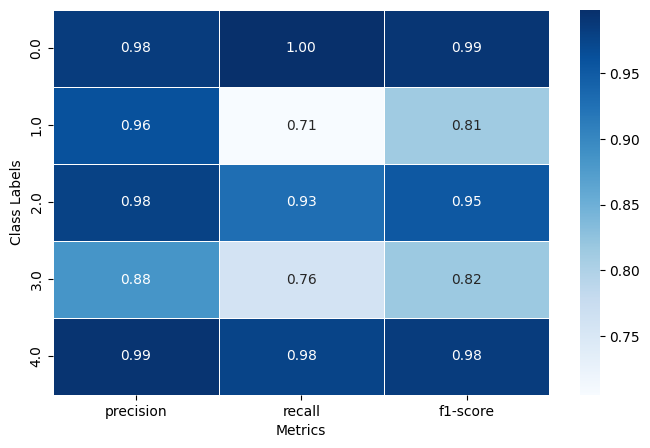

In [42]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).T.iloc[:-3, :-1] 

plt.figure(figsize=(8, 5))
sns.heatmap(df_report, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
# plt.title("Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Class Labels")
plt.show()


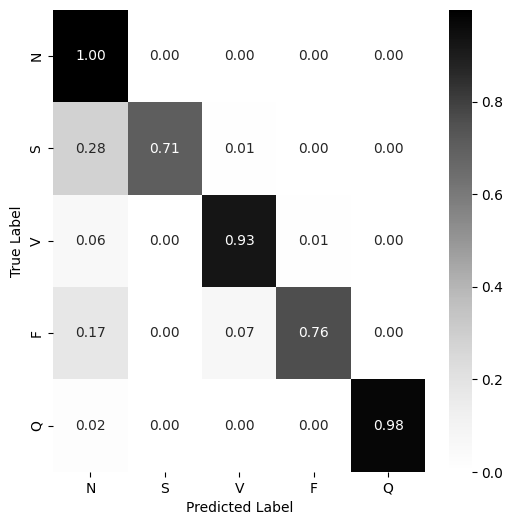

In [ ]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

class_labels = ["N", "S", "V", "F", "Q"] 

plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Greys", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
# plt.title("   ")

plt.show()

In [46]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

balanced_acc= balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Accuracy: 0.9830
Balanced Accuracy: 0.8735


---